# Setting kaggle

In [0]:
# to upload files
from google.colab import files

# install Kaggle library
# !pip list
# !pip install -q kaggle

In [2]:
# upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten

from PIL import Image
import requests
from io import BytesIO

import zipfile
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [4]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:50<00:00, 35.0MB/s]
100% 2.29G/2.29G [00:50<00:00, 48.9MB/s]


In [3]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zipimg:
  zipimg.extractall()

base_dir = os.getcwd()
test_img_dir = os.path.join(base_dir, 'chest_xray/test'); display(test_img_dir)
train_img_dir = os.path.join(base_dir, 'chest_xray/train'); display(train_img_dir)
val_img_dir = os.path.join(base_dir, 'chest_xray/val'); display(val_img_dir)

'/content/chest_xray/test'

'/content/chest_xray/train'

'/content/chest_xray/val'

# EDA

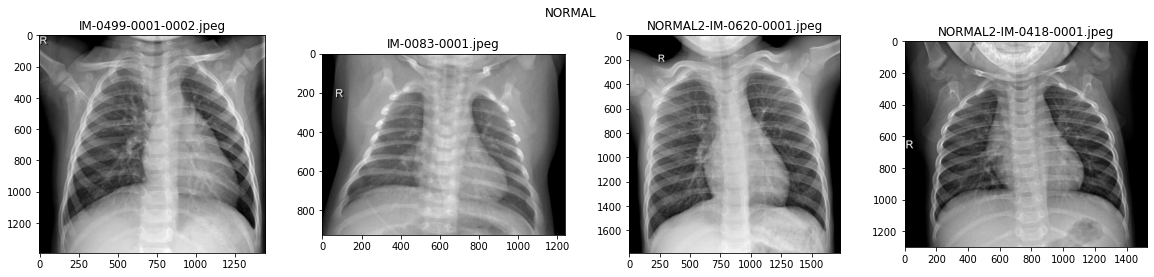

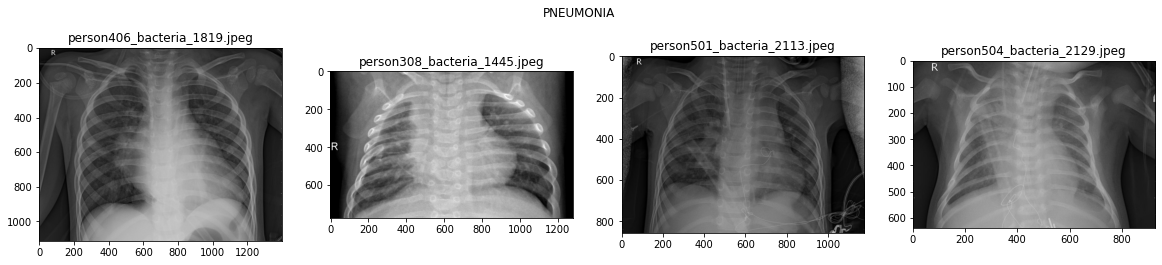

In [4]:
img_normal = []
img_pneumonia = []
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'NORMAL')):
    for filename in filenames:
        img_normal.append(os.path.join(dirname, filename))
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'PNEUMONIA')):
    for filename in filenames:
        img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=4).tolist()):
  ax[i].imshow(load_img(img_normal[j]))
  ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=4).tolist()):
  ax[i].imshow(load_img(img_pneumonia[j]))
  ax[i].set_title(img_pneumonia[j].split('/')[-1]);

From the pictures, I can tell you there are differences in the rib cage shape of the patient who has pneumonia compared to normal chest.
- Somehow the x-ray return more clear image in normal person and foggy image in infected.
- Also, normal chest is relatively symetric between the right and the left part.

# Data Preparation

- resize
- ImageDataGenerator might causes "bleeding"

# Data Generator

ImageDataGenerator

In [0]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 20

In [6]:
train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=10,  # degrees
                   zoom_range=0.15,
                   width_shift_range=0.15,  # per cent width
                   height_shift_range=0.15,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.2,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                      val_img_dir,
                                                      target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='binary',
                                                      )

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                        test_img_dir,
                                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='binary',
                                                        )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
NB_TRAIN_SAMPLES = 5216
NB_VAL_SAMPLES = 16
NB_TEST_SAMPLES = 624

# Create Model

In [8]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               530854

# Fit Model

In [10]:
EPOCHS = 20

history = model.fit_generator(
              train_generator,
              steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=val_generator,
              validation_steps=1,
              # callbacks=,
              )

Epoch 1/20
260/260 [==============================] - 69s 264ms/step - loss: 0.2793 - accuracy: 0.8831 - val_loss: 0.7644 - val_accuracy: 0.6250
Epoch 2/20
260/260 [==============================] - 69s 266ms/step - loss: 0.2461 - accuracy: 0.8953 - val_loss: 0.9985 - val_accuracy: 0.6250
Epoch 3/20
260/260 [==============================] - 69s 267ms/step - loss: 0.2344 - accuracy: 0.9067 - val_loss: 0.9529 - val_accuracy: 0.6875
Epoch 4/20
260/260 [==============================] - 70s 269ms/step - loss: 0.2311 - accuracy: 0.9078 - val_loss: 0.5429 - val_accuracy: 0.8125
Epoch 5/20
260/260 [==============================] - 70s 270ms/step - loss: 0.1965 - accuracy: 0.9199 - val_loss: 0.2970 - val_accuracy: 0.9375
Epoch 6/20
260/260 [==============================] - 69s 267ms/step - loss: 0.1828 - accuracy: 0.9299 - val_loss: 0.2944 - val_accuracy: 0.8750
Epoch 7/20
260/260 [==============================] - 69s 267ms/step - loss: 0.1845 - accuracy: 0.9271 - val_loss: 0.6054 - val_ac

In [16]:
model.evaluate(test_generator,
               steps=NB_TEST_SAMPLES//BATCH_SIZE)

31/31 [==============================] - 5s 149ms/step - loss: 0.3483 - accuracy: 0.9073


[0.3482610285282135, 0.9072847962379456]

# Evaluation

Evaluation Criteria :

- Still overfit for epoch 20
- Try higher batch_size, lower lr, higher epoch

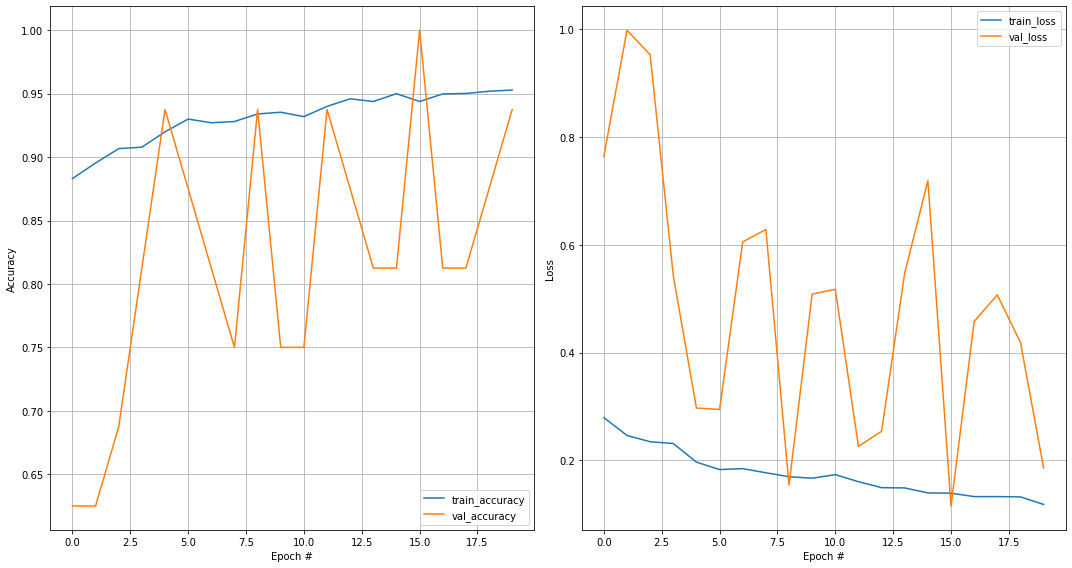

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

ax[0].plot(history.epoch, history.history['accuracy'], label='train_accuracy')
ax[0].plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch #')
ax[0].grid()
# ax[0].set_xlim(30,120)
# ax[0].set_ylim(0,.3)

ax[1].plot(history.epoch, history.history['loss'], label='train_loss')
ax[1].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch #')
ax[1].grid()
# ax[0].set_xlim(30,120)
# ax[0].set_ylim(0,.3)

plt.tight_layout();

In [0]:
# try image from other source

# newpath = os.path.join(os.getcwd(), 'other_image')
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

url_list = ["https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg",
            "https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg",
            "https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg",
            "https://prod-images-static.radiopaedia.org/images/554213/354346b4e955364dd7e27c4187e481_jumbo.jpg"
            ]
for url in url_list:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))